### Imports

In [12]:
import jax.numpy as jnp
from jax import jit

from jax.config import config

from pekf.parallel import ekf, eks, ieks
from pekf.sequential import ekf as seq_ekf, eks as seq_eks, ieks as seq_ieks
from pekf.models.bearings import get_data, make_parameters, plot_bearings
from pekf.utils import MVNormalParameters

config.update("jax_debug_nans", True)
config.update("jax_enable_x64", True)

### Input parameters

In [13]:
s1 = jnp.array([-1.5, 0.5])  # First sensor location
s2 = jnp.array([1., 1.])  # Second sensor location
r = 0.5  # Observation noise (stddev)
dt = 0.01  # discretization time step
x0 = jnp.array([0.1, 0.2, 1, 0])  # initial true location
qc = 0.01  # discretization noise
qw = 0.1  # discretization noise

T = 1000  # number of observations

### Get parameters

In [14]:
Q, R, observation_function, transition_function = make_parameters(qc, qw, r, dt, s1, s2)

### Get data

In [15]:
ts, true_states, observations = get_data(x0, dt, r, T, s1, s2, random_state=42)

### We can now run the filter and smoother

Initial state guess

In [16]:
m = jnp.array([-1., -1., 0., 0., 0.])
P = jnp.eye(5)

initial_guess = MVNormalParameters(m, P)

Run the filter

In [17]:
initial_states = MVNormalParameters(jnp.zeros((T, 5)), jnp.repeat(jnp.eye(5).reshape(1, 5, 5), T, axis=0))

In [18]:
filtered = ekf(initial_guess, 
               observations, 
               transition_function, 
               Q, 
               observation_function, 
               R, 
               initial_states.mean)

In [19]:
smoothed = eks(transition_function, Q, filtered)

### And the iterated one

In [20]:
iterated_smoothed_trajectories = ieks(initial_guess, 
                                      observations, 
                                      transition_function, 
                                      Q, 
                                      observation_function, 
                                      R, 
                                      initial_states, 
                                      n_iter=100)

In [21]:
seq_iterated_smoothed_trajectories = seq_ieks(initial_guess, 
                                              observations, 
                                              transition_function, 
                                              Q, 
                                              observation_function, 
                                              R, 
                                              initial_states, 
                                              n_iter=100)

### For comparison we can run the sequential iterated smoother too

### Plot the result

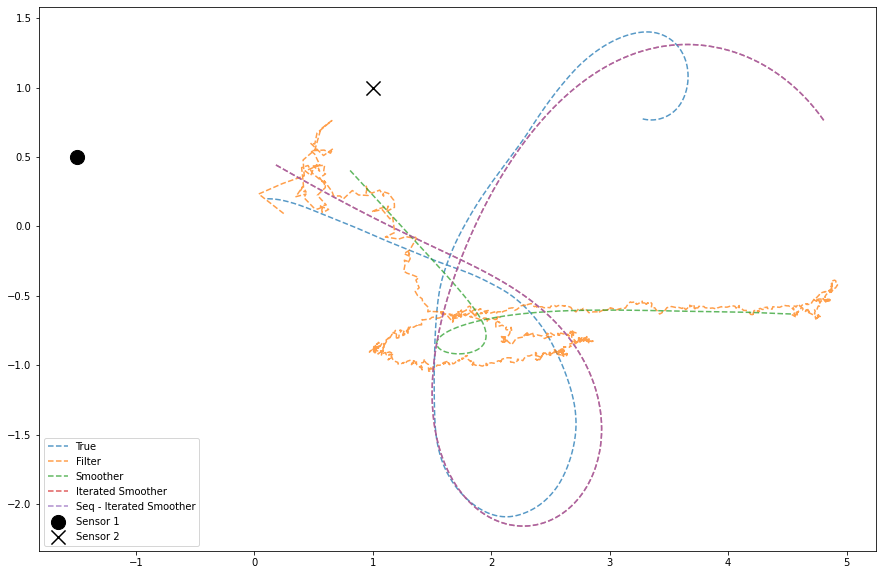

In [22]:
plot_bearings([true_states, filtered.mean, smoothed.mean, iterated_smoothed_trajectories.mean, seq_iterated_smoothed_trajectories.mean], 
              ["True", "Filter", "Smoother", "Iterated Smoother", "Seq - Iterated Smoother"], 
              s1, s2, figsize=(15, 10), quiver=False)